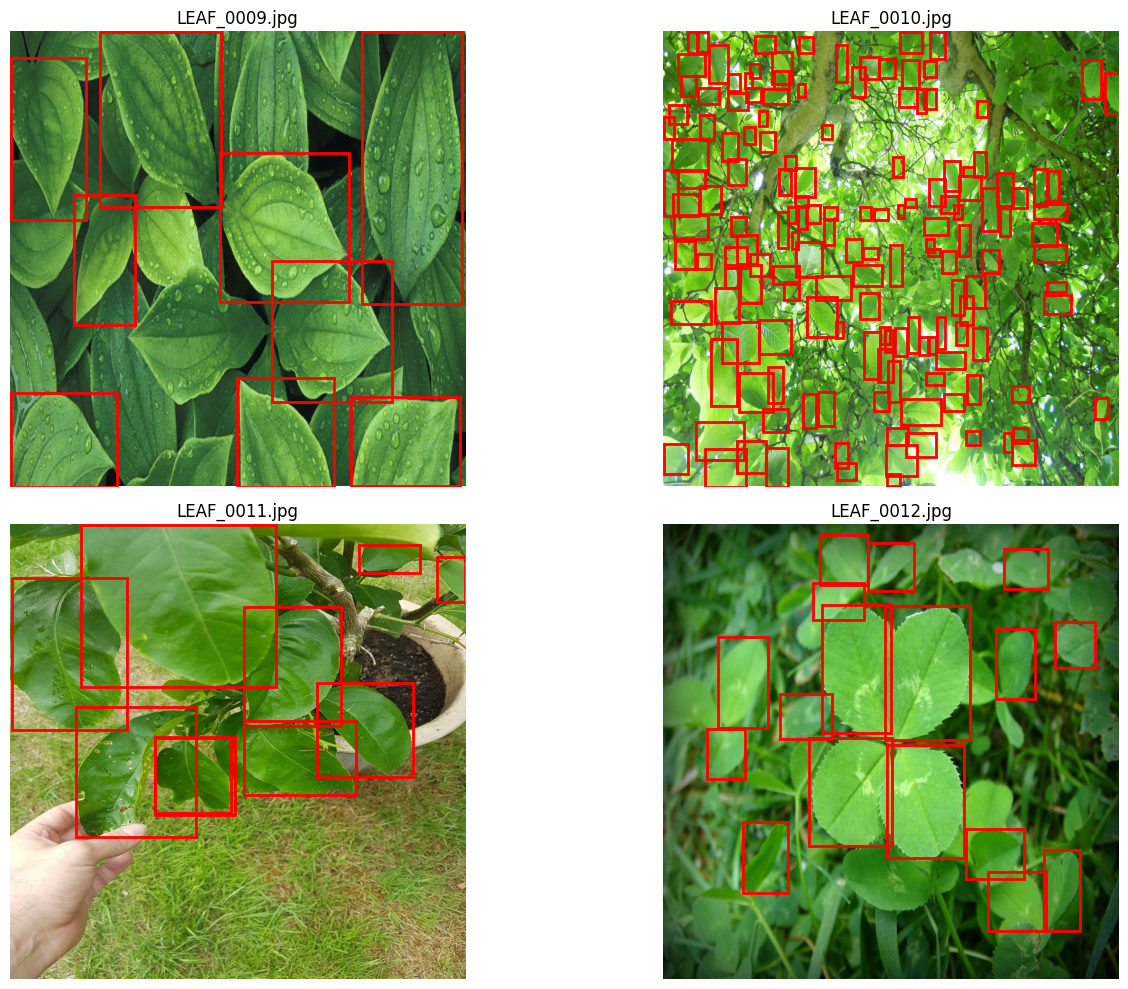

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os
import ast  # For safe string evaluation

# Configuration
CSV_PATH = '/kaggle/input/leaf-detection/train.csv'
IMAGE_DIR = '/kaggle/input/leaf-detection/train'  # Update if your images are elsewhere
NUM_SAMPLES = 4  # Number of images to display
GRID_SIZE = (2, 2)  # (rows, columns)

# Load and preprocess data
df = pd.read_csv(CSV_PATH)

# Convert bbox strings to lists
def convert_bbox(bbox_str):
    try:
        return ast.literal_eval(bbox_str)
    except:
        return [int(x) for x in bbox_str.strip('[]').split(',')]
        
df['bbox'] = df['bbox'].apply(convert_bbox)

# Group boxes by image
grouped = df.groupby('image_id')

# Create visualization
fig, axes = plt.subplots(GRID_SIZE[0], GRID_SIZE[1], figsize=(15, 10))
axes = axes.flatten()

for i, (img_id, group) in enumerate(grouped):
    if i >= NUM_SAMPLES:
        break
        
    try:
        # Load image
        img_path = os.path.join(IMAGE_DIR, img_id)
        img = Image.open(img_path)
        ax = axes[i]
        ax.imshow(img)
        ax.set_title(img_id)
        ax.axis('off')
        
        # Draw bounding boxes
        for _, row in group.iterrows():
            x, y, w, h = row['bbox']
            rect = patches.Rectangle(
                (x, y), w, h, 
                linewidth=2, 
                edgecolor='r', 
                facecolor='none'
            )
            ax.add_patch(rect)
            
    except Exception as e:
        print(f"Error processing {img_id}: {str(e)}")
        ax.axis('off')  # Turn off empty axes if error occurs

plt.tight_layout()
plt.show()

In [ ]:
# ================ SYNTHETIC DATA GENERATION ================
import os
import random
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import albumentations as A
import ast

# Configuration
ORIGINAL_CSV = '/kaggle/input/leaf-detection/train.csv'
IMAGE_DIR = '/kaggle/input/leaf-detection/train'
OUTPUT_DIR = '/kaggle/working/leaf_dataset'
SYNTHETIC_DIR = os.path.join(OUTPUT_DIR, 'synthetic')
SYNTHETIC_CSV = os.path.join(SYNTHETIC_DIR, 'synthetic.csv')
COMBINED_CSV = os.path.join(OUTPUT_DIR, 'combined.csv')

NUM_SYNTHETIC_IMAGES = 500
MIN_LEAVES_PER_IMAGE = 2
MAX_LEAVES_PER_IMAGE = 8
IMAGE_SIZE = (1024, 1024)  # Match original image size

# Create directories
os.makedirs(SYNTHETIC_DIR, exist_ok=True)
os.makedirs(os.path.join(SYNTHETIC_DIR, 'images'), exist_ok=True)
os.makedirs(os.path.join(SYNTHETIC_DIR, 'crops'), exist_ok=True)

# Load and process original data
df = pd.read_csv(ORIGINAL_CSV)
df['bbox'] = df['bbox'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Extract leaf crops
print("Extracting leaf crops for synthetic generation...")
crop_info = []
for idx, row in df.iterrows():
    img_path = os.path.join(IMAGE_DIR, row['image_id'])
    img = cv2.imread(img_path)
    if img is None:
        continue
        
    x, y, w, h = row['bbox']
    crop = img[y:y+h, x:x+w]
    
    if crop.size == 0:
        continue
        
    crop_path = os.path.join(SYNTHETIC_DIR, 'crops', f"crop_{idx}.png")
    cv2.imwrite(crop_path, crop)
    crop_info.append(crop_path)

# Background generators
def gaussian_noise_background(size):
    h, w = size
    intensity = random.uniform(0.02, 0.08)
    noise = np.random.normal(0, intensity, (h, w, 3))
    return (noise * 255).clip(0, 255).astype(np.uint8)

def texture_background(size):
    h, w = size
    img = np.zeros((h, w, 3), dtype=np.uint8)
    base_hue = random.randint(30, 90)
    img[:, :, 0] = base_hue
    img[:, :, 1] = random.randint(30, 100)
    img[:, :, 2] = random.randint(30, 100)
    img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
    noise = np.random.randint(-25, 25, (h, w, 3), dtype=np.int16)
    img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)
    return cv2.GaussianBlur(img, (5, 5), 0)

# Fixed leaf augmentations (handles alpha channel properly)
def augment_leaf(leaf):
    # Separate alpha channel if exists
    has_alpha = leaf.shape[2] == 4
    if has_alpha:
        rgb = leaf[:, :, :3]
        alpha = leaf[:, :, 3]
    else:
        rgb = leaf
    
    # Apply color augmentations to RGB only
    augmenter = A.Compose([
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGamma(p=0.3),
    ])
    augmented = augmenter(image=rgb)
    rgb_aug = augmented['image']
    
    # Apply geometric transformations to entire image
    if has_alpha:
        # Combine back with alpha
        leaf = np.dstack((rgb_aug, alpha))
        
        # Apply rotation with transparency preservation
        if random.random() < 0.8:
            angle = random.uniform(-180, 180)
            h, w = leaf.shape[:2]
            matrix = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
            leaf = cv2.warpAffine(
                leaf, matrix, (w, h),
                flags=cv2.INTER_LINEAR,
                borderMode=cv2.BORDER_CONSTANT,
                borderValue=(0, 0, 0, 0))
    
    # Apply blur to RGB channels only
    if random.random() < 0.3:
        ksize = random.choice([3, 5])
        if has_alpha:
            leaf[:, :, :3] = cv2.GaussianBlur(leaf[:, :, :3], (ksize, ksize), 0)
        else:
            leaf = cv2.GaussianBlur(leaf, (ksize, ksize), 0)
    
    return leaf

# Create synthetic images
print(f"Generating {NUM_SYNTHETIC_IMAGES} synthetic images...")
synthetic_data = []

for i in range(NUM_SYNTHETIC_IMAGES):
    # Create background
    bg_type = random.choice([gaussian_noise_background, texture_background])
    bg = bg_type(IMAGE_SIZE)
    
    # Create blank image
    composite = np.zeros((*IMAGE_SIZE, 4), dtype=np.uint8)
    composite[:, :, :3] = bg
    composite[:, :, 3] = 255  # Alpha channel
    
    bboxes = []
    num_leaves = random.randint(MIN_LEAVES_PER_IMAGE, MAX_LEAVES_PER_IMAGE)
    
    for _ in range(num_leaves):
        crop_path = random.choice(crop_info)
        leaf = cv2.imread(crop_path, cv2.IMREAD_UNCHANGED)
        if leaf is None:
            continue
            
        # Ensure 4-channel RGBA format
        if leaf.shape[2] == 3:
            leaf = cv2.cvtColor(leaf, cv2.COLOR_BGR2BGRA)
        
        # Apply augmentations
        leaf = augment_leaf(leaf)
        
        # Random scale with size validation
        scale = random.uniform(0.5, 1.5)
        orig_h, orig_w = leaf.shape[:2]
        new_h = max(1, int(orig_h * scale))
        new_w = max(1, int(orig_w * scale))
        leaf = cv2.resize(leaf, (new_w, new_h))
        
        # Skip if leaf is larger than background
        if leaf.shape[0] > IMAGE_SIZE[0] or leaf.shape[1] > IMAGE_SIZE[1]:
            continue
            
        # Calculate valid position range
        max_y = IMAGE_SIZE[0] - leaf.shape[0]
        max_x = IMAGE_SIZE[1] - leaf.shape[1]
        
        # Skip if no valid position
        if max_y < 0 or max_x < 0:
            continue
            
        # Random position
        y1 = random.randint(0, max_y)
        x1 = random.randint(0, max_x)
        y2 = y1 + leaf.shape[0]
        x2 = x1 + leaf.shape[1]
        
        # Blend leaf with alpha compositing
        alpha = leaf[:, :, 3] / 255.0
        for c in range(3):
            composite[y1:y2, x1:x2, c] = (
                alpha * leaf[:, :, c] + 
                (1 - alpha) * composite[y1:y2, x1:x2, c]
            )
        
        bboxes.append([x1, y1, leaf.shape[1], leaf.shape[0]])
    
    # Save image
    img_id = f"synthetic_{i}.jpg"
    img_path = os.path.join(SYNTHETIC_DIR, 'images', img_id)
    cv2.imwrite(img_path, composite[:, :, :3])
    
    # Save annotations
    for bbox in bboxes:
        synthetic_data.append({
            'image_id': img_id,
            'width': IMAGE_SIZE[1],
            'height': IMAGE_SIZE[0],
            'bbox': bbox
        })

# Create synthetic DataFrame
synthetic_df = pd.DataFrame(synthetic_data)
synthetic_df.to_csv(SYNTHETIC_CSV, index=False)

# Combine with original data
combined_df = pd.concat([df, synthetic_df])
combined_df.to_csv(COMBINED_CSV, index=False)
print(f"Synthetic data generated! Total leaf instances: {len(combined_df)}")

# ================ YOLOv8 DATASET CONVERSION ================
DEST_DIR = '/kaggle/working/yolov8_leaf'
YAML_PATH = os.path.join(DEST_DIR, 'leaf.yaml')

# Create dataset structure
os.makedirs(os.path.join(DEST_DIR, 'images', 'train'), exist_ok=True)
os.makedirs(os.path.join(DEST_DIR, 'images', 'val'), exist_ok=True)
os.makedirs(os.path.join(DEST_DIR, 'labels', 'train'), exist_ok=True)
os.makedirs(os.path.join(DEST_DIR, 'labels', 'val'), exist_ok=True)

# Split data (using original + synthetic)
train_ids, val_ids = train_test_split(
    combined_df['image_id'].unique(), 
    test_size=0.2, 
    random_state=42
)

# Conversion function
def convert_to_yolo(row):
    x, y, w, h = row['bbox']
    if not isinstance(x, int):
        x, y, w, h = map(int, [x, y, w, h])
        
    x_center = (x + w/2) / row['width']
    y_center = (y + h/2) / row['height']
    w_norm = w / row['width']
    h_norm = h / row['height']
    
    return f"0 {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}"

# Process and save data
def process_dataset(image_ids, dataset_type):
    for img_id in image_ids:
        # Determine source directory
        if img_id.startswith('synthetic_'):
            src_dir = os.path.join(SYNTHETIC_DIR, 'images')
        else:
            src_dir = IMAGE_DIR
            
        # Copy image
        src_img = os.path.join(src_dir, img_id)
        dest_img = os.path.join(DEST_DIR, 'images', dataset_type, img_id)
        shutil.copy(src_img, dest_img)
        
        # Create label file
        label_path = os.path.join(DEST_DIR, 'labels', dataset_type, 
                                 os.path.splitext(img_id)[0] + '.txt')
        img_data = combined_df[combined_df['image_id'] == img_id]
        
        with open(label_path, 'w') as f:
            for _, row in img_data.iterrows():
                f.write(convert_to_yolo(row) + '\n')

# Execute conversion
print("Converting dataset to YOLOv8 format...")
process_dataset(train_ids, 'train')
process_dataset(val_ids, 'val')

# Create YAML configuration
yaml_content = f"""
path: {DEST_DIR}
train: images/train
val: images/val

# Number of classes
nc: 1

# Class names
names: ['leaf']
"""

with open(YAML_PATH, 'w') as f:
    f.write(yaml_content)

print("Dataset conversion complete!")

# ================ YOLOv8 TRAINING ================
from ultralytics import YOLO

print("Starting YOLOv8 training...")
model = YOLO('yolov8m.pt')  # Medium-sized model

results = model.train(
    data=YAML_PATH,
    epochs=100,
    batch=16,
    imgsz=640,
    patience=20,
    device=0,
    name='leaf_detection',
    optimizer='AdamW',
    lr0=0.001,
    augment=True,
    mixup=0.1,
    hsv_h=0.015,
    hsv_s=0.7,
    fliplr=0.5,
    degrees=10
)

print("Training completed!")

Extracting leaf crops for synthetic generation...
Generating 500 synthetic images...
Synthetic data generated! Total leaf instances: 7843
Converting dataset to YOLOv8 format...
Dataset conversion complete!
Starting YOLOv8 training...


100%|██████████| 49.7M/49.7M [00:00<00:00, 258MB/s]


Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolov8_leaf/leaf.yaml, degrees=10, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=leaf_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=1

100%|██████████| 5.35M/5.35M [00:00<00:00, 74.6MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2213.6±2201.5 MB/s, size: 228.7 KB)


train: Scanning /kaggle/working/yolov8_leaf/labels/train... 1304 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1304/1304 [00:00<00:00, 1402.47it/s]

train: New cache created: /kaggle/working/yolov8_leaf/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 313.5±150.2 MB/s, size: 114.9 KB)


val: Scanning /kaggle/working/yolov8_leaf/labels/val... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<00:00, 599.62it/s]

val: New cache created: /kaggle/working/yolov8_leaf/labels/val.cache


Plotting labels to runs/detect/leaf_detection/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/leaf_detection
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.88G      1.394        1.5        1.6         41        640: 100%|██████████| 82/82 [00:44<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.36it/s]

                   all        326       1472      0.659      0.454      0.534      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.44G      1.416      1.337      1.576         40        640: 100%|██████████| 82/82 [00:43<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.36it/s]

                   all        326       1472      0.575      0.501      0.528       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.65G      1.437      1.361      1.629         67        640: 100%|██████████| 82/82 [00:43<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.35it/s]

                   all        326       1472      0.598      0.543      0.561      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       6.4G      1.395       1.33      1.597         54        640: 100%|██████████| 82/82 [00:42<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.36it/s]

                   all        326       1472      0.657       0.58      0.622      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.55G      1.371      1.303      1.595         59        640: 100%|██████████| 82/82 [00:42<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.38it/s]

                   all        326       1472      0.727      0.552      0.659      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.99G      1.373      1.263      1.585         46        640: 100%|██████████| 82/82 [00:43<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.37it/s]

                   all        326       1472      0.699      0.651      0.702      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.59G      1.349      1.268       1.57         77        640: 100%|██████████| 82/82 [00:42<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.37it/s]

                   all        326       1472      0.766      0.609      0.739      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.61G      1.311      1.221      1.547         81        640: 100%|██████████| 82/82 [00:43<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.39it/s]

                   all        326       1472      0.717       0.64      0.729      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.53G      1.276      1.204      1.531         47        640: 100%|██████████| 82/82 [00:42<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.38it/s]

                   all        326       1472      0.749       0.65      0.749      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.67G      1.274      1.167      1.503         44        640: 100%|██████████| 82/82 [00:43<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.37it/s]

                   all        326       1472      0.768      0.615      0.742      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.45G      1.235      1.131      1.505         55        640: 100%|██████████| 82/82 [00:42<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.39it/s]

                   all        326       1472      0.743      0.612       0.71      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.41G      1.234      1.128      1.497         57        640: 100%|██████████| 82/82 [00:43<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.40it/s]

                   all        326       1472       0.76      0.647      0.752       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.41G      1.228      1.098      1.488         47        640: 100%|██████████| 82/82 [00:42<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.37it/s]

                   all        326       1472      0.797      0.639      0.763      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.73G      1.239      1.106      1.492        133        640: 100%|██████████| 82/82 [00:43<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.38it/s]

                   all        326       1472      0.732       0.65      0.744      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.59G      1.221      1.083      1.465         61        640: 100%|██████████| 82/82 [00:43<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.38it/s]

                   all        326       1472       0.76      0.679      0.773      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.91G      1.199      1.072      1.463         58        640: 100%|██████████| 82/82 [00:43<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.33it/s]

                   all        326       1472      0.791      0.666      0.785      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       6.6G      1.179      1.018      1.438         56        640: 100%|██████████| 82/82 [00:43<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.39it/s]

                   all        326       1472      0.796      0.665      0.785      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.38G      1.165      1.014      1.427        123        640: 100%|██████████| 82/82 [00:43<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.40it/s]

                   all        326       1472      0.777      0.707      0.795      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.32G      1.148     0.9967       1.42         58        640: 100%|██████████| 82/82 [00:42<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.39it/s]

                   all        326       1472      0.802      0.661      0.784       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.88G      1.175      1.035      1.447         41        640: 100%|██████████| 82/82 [00:42<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.36it/s]

                   all        326       1472      0.753      0.633      0.738      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.42G      1.161      1.008      1.424         84        640: 100%|██████████| 82/82 [00:42<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.36it/s]

                   all        326       1472      0.749      0.694      0.788      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.37G      1.173      1.037      1.446         54        640: 100%|██████████| 82/82 [00:43<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.38it/s]

                   all        326       1472      0.774      0.679      0.781      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.58G      1.118     0.9651      1.395         63        640: 100%|██████████| 82/82 [00:42<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.38it/s]

                   all        326       1472      0.762      0.704      0.797      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.71G      1.168      1.018      1.426         39        640: 100%|██████████| 82/82 [00:43<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.39it/s]

                   all        326       1472      0.759      0.674      0.775      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.52G      1.124     0.9694      1.407         96        640: 100%|██████████| 82/82 [00:42<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.40it/s]

                   all        326       1472      0.788      0.659      0.783      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.63G      1.106     0.9451      1.405         46        640: 100%|██████████| 82/82 [00:42<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.40it/s]

                   all        326       1472       0.78      0.678      0.798      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.43G      1.103     0.9615      1.389         62        640: 100%|██████████| 82/82 [00:43<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.38it/s]

                   all        326       1472      0.759      0.688      0.791      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.38G      1.129      0.942        1.4         61        640: 100%|██████████| 82/82 [00:42<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.40it/s]

                   all        326       1472       0.74      0.743      0.813      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.57G      1.099     0.9267      1.382         51        640: 100%|██████████| 82/82 [00:42<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.39it/s]

                   all        326       1472      0.779      0.714      0.822      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.94G      1.113     0.9375      1.387        100        640: 100%|██████████| 82/82 [00:43<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.39it/s]

                   all        326       1472      0.802      0.704      0.823      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.68G      1.095     0.9197      1.379        112        640: 100%|██████████| 82/82 [00:42<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.40it/s]

                   all        326       1472      0.767      0.731      0.816      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.55G      1.112     0.9451      1.392         75        640: 100%|██████████| 82/82 [00:42<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.40it/s]

                   all        326       1472      0.814      0.674      0.814      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.63G      1.081     0.8788      1.357         68        640: 100%|██████████| 82/82 [00:43<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.41it/s]

                   all        326       1472      0.747      0.751      0.827      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.93G      1.073     0.9183       1.37        125        640: 100%|██████████| 82/82 [00:42<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.41it/s]

                   all        326       1472      0.795      0.695      0.819       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.95G      1.106     0.9177      1.376         96        640: 100%|██████████| 82/82 [00:42<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.38it/s]

                   all        326       1472      0.764      0.733       0.82      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.85G      1.067     0.8867      1.356        106        640: 100%|██████████| 82/82 [00:43<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.39it/s]

                   all        326       1472      0.794      0.696      0.813      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.74G      1.071     0.8771      1.344         65        640: 100%|██████████| 82/82 [00:43<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.41it/s]

                   all        326       1472      0.759       0.73       0.81      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.25G      1.063     0.8929      1.351         39        640: 100%|██████████| 82/82 [00:43<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.38it/s]

                   all        326       1472      0.785      0.711      0.816      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.58G      1.067      0.883      1.361         78        640: 100%|██████████| 82/82 [00:43<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.39it/s]

                   all        326       1472       0.79       0.71      0.815      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.63G      1.041     0.8704      1.339         75        640: 100%|██████████| 82/82 [00:43<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.39it/s]

                   all        326       1472      0.784      0.712      0.816      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.33G      1.068     0.8766      1.367         62        640: 100%|██████████| 82/82 [00:42<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.39it/s]

                   all        326       1472      0.803      0.732      0.829       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.71G      1.056     0.8726       1.35         59        640: 100%|██████████| 82/82 [00:42<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.41it/s]

                   all        326       1472      0.814      0.734       0.84      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.56G      1.018     0.8278       1.33         43        640: 100%|██████████| 82/82 [00:43<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.40it/s]

                   all        326       1472      0.768      0.726      0.809      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.38G      1.019     0.8417      1.336         93        640: 100%|██████████| 82/82 [00:42<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.41it/s]

                   all        326       1472      0.785      0.725      0.826        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.72G      1.082     0.9068      1.337        120        640:  24%|██▍       | 20/82 [00:11<00:32,  1.88it/s]

In [12]:
import os
import shutil
import glob

def clean_kaggle_working():
    """Safely deletes all files and directories in /kaggle/working except the notebook"""
    working_dir = '/kaggle/working'
    
    # Get current notebook name to preserve it
    current_notebook = glob.glob(os.path.join(working_dir, '*.ipynb'))
    
    # Delete files
    for filename in os.listdir(working_dir):
        filepath = os.path.join(working_dir, filename)
        
        # Skip current notebook files
        if filepath in current_notebook:
            continue
            
        try:
            if os.path.isfile(filepath) or os.path.islink(filepath):
                os.unlink(filepath)
            elif os.path.isdir(filepath):
                shutil.rmtree(filepath)
        except Exception as e:
            print(f"Error deleting {filepath}: {str(e)}")
    
    print("Working directory cleaned successfully!")
    print(f"Preserved notebook: {current_notebook[0] if current_notebook else 'None'}")

# Execute the cleanup
clean_kaggle_working()

Working directory cleaned successfully!
Preserved notebook: None
